In [1]:

from tqdm.auto import tqdm

from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import (col, lit, from_unixtime, to_timestamp,
                                   year, weekofyear, hour, concat_ws)
import pyarrow

try:
    spark.stop()
except:
    pass

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
      .master("spark://spark:7077")
      .appName("WiClean+")
      .config("spark.driver.memory",   "16g")
      .config("spark.executor.memory", "16g")

      .config("spark.kryoserializer.buffer.max", "1024m")
      .config("spark.sql.shuffle.partitions", "200")
      .config("spark.default.parallelism",     "200")
      .getOrCreate()
)

# sanity check to verify spark works in docker
spark.range(5).show()



/home/caelunshun/dev/cs6964/final/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
25/04/28 22:16:44 WARN Utils: Your hostname, hyperbola resolves to a loopback address: 127.0.1.1; using 192.168.0.66 instead (on interface enp6s0)
25/04/28 22:16:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 22:16:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+



In [3]:
from pyspark.sql import functions as F
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


 Weekly features filtered to top-10k articles: 283,264 rows
 Weekly features shape for training: (283264, 8)

=== Testing contamination=0.001 ===
 Total anomalies detected: 257
 Worst anomaly scores: [np.float64(-0.028935927861272637), np.float64(-0.028935927861272637), np.float64(-0.028935927861272637), np.float64(-0.028935927861272637), np.float64(-0.028935927861272637)]

=== Testing contamination=0.003 ===
 Total anomalies detected: 846
 Worst anomaly scores: [np.float64(-0.05800871839763799), np.float64(-0.05800871839763799), np.float64(-0.05800871839763799), np.float64(-0.05800871839763799), np.float64(-0.05800871839763799)]

=== Testing contamination=0.005 ===
 Total anomalies detected: 1416
 Worst anomaly scores: [np.float64(-0.08182234176984793), np.float64(-0.08182234176984793), np.float64(-0.08182234176984793), np.float64(-0.08182234176984793), np.float64(-0.08182234176984793)]

=== Testing contamination=0.01 ===
 Total anomalies detected: 2824
 Worst anomaly scores: [np.floa

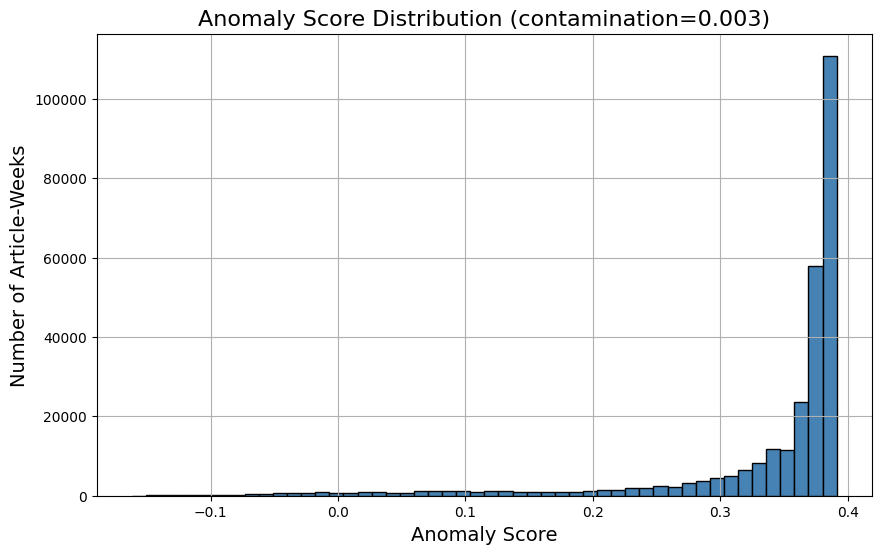

In [4]:

# load weekly feature matrix from preprocess
weekly_feats = spark.read.parquet("data/weekly_feats_v23.parquet")

# load Top-10k typed pages from preprocess
top10k = spark.read.parquet("data/top10k_typed_pages.parquet")

#Filter weekly_feats to only those src_articles
weekly_filtered = weekly_feats.join(
    top10k.select("article_id"),
    weekly_feats.src_article == top10k.article_id,
    how="inner"
)

print(f" Weekly features filtered to top-10k articles: {weekly_filtered.count():,} rows")

# select feature columns
feature_cols = ["total_edits", "adds", "removes", "unique_targets", "revert_count", "odd_hour_edits"]

# convert to pandas for scikit learn
weekly_pd = weekly_filtered.select(
    "src_article", "week", *feature_cols
).toPandas()

print(f" Weekly features shape for training: {weekly_pd.shape}")

# standardize features
scaler = StandardScaler()
X = scaler.fit_transform(weekly_pd[feature_cols])


# Try in different contamination values

contamination_rates = [0.001, 0.003, 0.005, 0.01, 0.02]

results = []

for cont in contamination_rates:
    print(f"\n=== Testing contamination={cont} ===")

    iso = IsolationForest(
        n_estimators=100,
        max_samples="auto",
        contamination=cont,
        random_state=2345765,
        n_jobs=-1
    )
    iso.fit(X)

    anomaly_scores = iso.decision_function(X)
    predictions = iso.predict(X)

    # collect results
    total_anomalies = (predictions == -1).sum()
    worst_scores = sorted(anomaly_scores)[:5]
    print(f" Total anomalies detected: {total_anomalies}")
    print(f" Worst anomaly scores: {worst_scores}")

    results.append((cont, total_anomalies, worst_scores))


# save final model and anomalies
weekly_pd["anomaly_score_final"] = anomaly_scores
weekly_pd["anomaly_final"] = (predictions == -1)

# plot
plt.figure(figsize=(10,6))
plt.hist(weekly_pd["anomaly_score_final"], bins=50, color='steelblue', edgecolor='black')
plt.title("Anomaly Score Distribution (contamination=0.003)", fontsize=16)
plt.xlabel("Anomaly Score", fontsize=14)
plt.ylabel("Number of Article-Weeks", fontsize=14)
plt.grid(True)
plt.show()



In [5]:


# load weekly feature matrix from preprocess
weekly_feats = spark.read.parquet("data/weekly_feats_v23.parquet")

# load Top-10k typed pages (so we only detect anomalies on meaningful articles)
# from preprocess
top10k = spark.read.parquet("data/top10k_typed_pages.parquet")

# filter weekly_feats to only those src_articles
weekly_filtered = weekly_feats.join(
    top10k.select("article_id"),
    weekly_feats.src_article == top10k.article_id,
    how="inner"
)

print(f" Weekly features filtered to top-10k articles: {weekly_filtered.count():,} rows")

# select feature columns
feature_cols = ["total_edits", "adds", "removes", "unique_targets", "revert_count", "odd_hour_edits"]

# convert to pandas for scikit learn
weekly_pd = weekly_filtered.select(
    "src_article", "week", *feature_cols
).toPandas()

print(f" Weekly features shape for training: {weekly_pd.shape}")

# standardize features
scaler = StandardScaler()
X = scaler.fit_transform(weekly_pd[feature_cols])

# Train Isolation Forest
iso = IsolationForest(
    n_estimators=100,
    max_samples="auto",
    contamination=0.003,
    random_state=42,
    n_jobs=-1
)
iso.fit(X)

# predict anomaly scores
weekly_pd["anomaly_score"] = iso.decision_function(X)
weekly_pd["anomaly"] = iso.predict(X) == -1

# view top anomalies
top_anomalies = weekly_pd[weekly_pd["anomaly"]].sort_values("anomaly_score")

print(f" Total anomalies detected: {top_anomalies.shape[0]}")

print("\n=== Sample top anomalies ===")
print(top_anomalies[["src_article", "week", "anomaly_score"]].head(10))

# save anomalies
top_anomalies.to_csv("data/top_anomalies1.csv", index=False)
print("Anomalies saved to data folder")



 Weekly features filtered to top-10k articles: 283,264 rows
 Weekly features shape for training: (283264, 8)
 Total anomalies detected: 845

=== Sample top anomalies ===
        src_article     week  anomaly_score
260915        76547   2024-3      -0.055903
225216        19777  2023-13      -0.055903
211122      1933576  2023-22      -0.055320
211123      1933576  2023-22      -0.055320
222770       138970  2023-44      -0.054154
228210        29253  2023-27      -0.054154
32722         36248   2023-9      -0.054154
26899          4069  2024-12      -0.054154
218295        29253  2023-24      -0.054154
183344       138970  2024-44      -0.054154
Anomalies saved to Drive


In [7]:


# load the final anomalies with pattern matching results from 02_pattern_mining
anomalies = pd.read_csv("data/final_anomaly_pattern_results1.csv")

print(f" Total anomalies loaded: {len(anomalies):,}")

# show some samples of anomaly
print("\n=== Sample anomalies ===")
print(anomalies[["src_article", "week", "anomaly_score"]].sort_values("anomaly_score").head(10))

# group anomalies by article to see which articles had the most anomalies
article_counts = anomalies.groupby("src_article").size().sort_values(ascending=False)

print("\n=== Articles with most anomalies ===")
print(article_counts.head(10))





 Total anomalies loaded: 1,433

=== Sample anomalies ===
   src_article     week  anomaly_score
0         9855  2024-45      -0.082523
1       179793  2024-27      -0.082523
2       179793  2024-27      -0.082523
3      1933576  2023-22      -0.082523
4      1933576  2023-22      -0.082523
5       179793  2024-34      -0.081933
6       179793  2024-34      -0.081933
7         1259  2023-20      -0.081933
8         5878  2023-20      -0.081933
9        45951  2024-34      -0.081933

=== Articles with most anomalies ===
src_article
179793     18
40339      12
523900     12
1239921     9
933964      8
4995        8
404401      7
40349       7
32286       6
22700       6
dtype: int64


In [8]:
anomalies.head()

,src_article,week,total_edits,adds,removes,unique_targets,revert_count,odd_hour_edits,anomaly_score,anomaly,pattern_matched
0,9855,2024-45,7542,3771,3771,1282,1257,2514,-0.082523,True,False
1,179793,2024-27,6486,3243,3243,1701,1622,1622,-0.082523,True,False
2,179793,2024-27,6486,3243,3243,1701,1622,1622,-0.082523,True,False
3,1933576,2023-22,6728,3364,3364,1191,1137,2252,-0.082523,True,False
4,1933576,2023-22,6728,3364,3364,1191,1137,2252,-0.082523,True,False


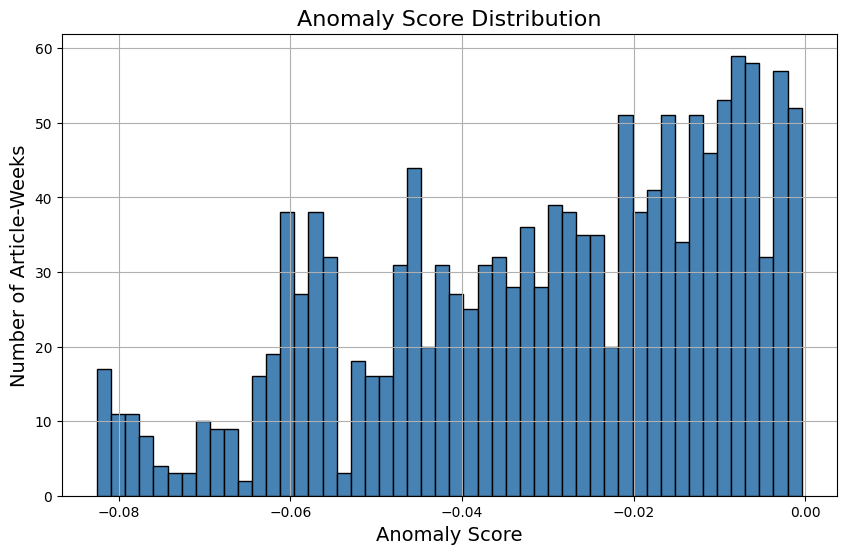

In [9]:
import matplotlib.pyplot as plt

# reload data
anomalies = pd.read_csv("data/final_anomaly_pattern_results1.csv")

# plot
plt.figure(figsize=(10,6))
plt.hist(anomalies['anomaly_score'], bins=50, color='steelblue', edgecolor='black')
plt.title("Anomaly Score Distribution", fontsize=16)
plt.xlabel("Anomaly Score", fontsize=14)
plt.ylabel("Number of Article-Weeks", fontsize=14)
plt.grid(True)
plt.show()


In [11]:


# load final anomaly results from previous cell
anomalies = pd.read_csv("data/final_anomaly_pattern_results1.csv")

print(f"Loaded {len(anomalies):,} anomalies")

# load article ID to title mapping from scraper
articles = spark.read.parquet("data/articles.parquet") \
            .select(col("id").alias("src_article"), "title") \
            .toPandas()

print(f"Loaded {len(articles):,} articles")

# merge titles into anomalies
anomalies_with_titles = anomalies.merge(articles, on="src_article", how="left")

# reorder columns for nice output
anomalies_with_titles = anomalies_with_titles[
    ["src_article", "title", "week", "anomaly_score", "pattern_matched"]
]

# save final CSV
anomalies_with_titles.to_csv("data/final_anomaly_pattern_results_with_titles1.csv", index=False)

print("Final anomaly CSV with titles saved!")


Loaded 1,433 anomalies


Loaded 17,909,529 articles
Final anomaly CSV with titles saved!


In [12]:
# load the transactions (article-week link sets)
# from 01_preprocess
transactions = spark.read.parquet("data/transactions_small.parquet")

anomalies = pd.read_csv("data/top_anomalies1.csv")

# convert transactions to pandas
transactions_pd = transactions.toPandas()

# build key = (src_article, week) -> items
transactions_pd["key"] = transactions_pd["src_article"].astype(str) + "_" + transactions_pd["week"]
tx_dict = transactions_pd.set_index("key")["items"].to_dict()

# add a key column to anomalies
anomalies["key"] = anomalies["src_article"].astype(str) + "_" + anomalies["week"]

# map items
anomalies["items_observed"] = anomalies["key"].map(tx_dict)

# save the enriched anomalies file
anomalies.to_csv("data/anomalies_with_items.csv", index=False)

print("New anamoly file with 'items_observed' saved")


New anamoly file with 'items_observed' saved


In [16]:

import glob

# load all frequent patterns

# regular mined pairs
regular_pairs_df = pd.read_parquet("data/top100_patterns.parquet")

# FPGrowth-mined patterns (
pattern_files2 = glob.glob("data/patterns_size2_csv_reduced/part-*")
pattern_files3 = glob.glob("data/patterns_size3_csv_reduced/part-*")

patterns2_df = pd.concat([pd.read_csv(f, names=["pattern", "freq"]) for f in pattern_files2], ignore_index=True)
patterns3_df = pd.concat([pd.read_csv(f, names=["pattern", "freq"]) for f in pattern_files3], ignore_index=True)

# build combined pattern sets
all_patterns = set()

# regular pairs
for pair in regular_pairs_df["pair"]:
    if isinstance(pair, list) or isinstance(pair, tuple):
        all_patterns.add(frozenset(pair))

# FPGrowth 2-item and 3-item patterns (split by '|')
for p in patterns2_df["pattern"]:
    all_patterns.add(frozenset(p.split("|")))

for p in patterns3_df["pattern"]:
    all_patterns.add(frozenset(p.split("|")))

print(f"Total combined patterns loaded: {len(all_patterns):,}")

# load anomalies and build item sets

anomalies = pd.read_csv("data/anomalies_with_items.csv")

if 'items_observed' not in anomalies.columns:
    raise ValueError(" 'items_observed' column missing. Cannot match patterns without it.")

anomalies["items_set"] = anomalies["items_observed"].apply(lambda s: set(s.split("|")))

# Pattern Matching Function
def is_explained(itemset):
    for pattern in all_patterns:
        if pattern.issubset(itemset):
            return True
    return False

# apply pattern matching
anomalies["pattern_matched"] = anomalies["items_set"].apply(is_explained)

# save explained vs unexplained anomalies
explained = anomalies[anomalies["pattern_matched"]]
unexplained = anomalies[~anomalies["pattern_matched"]]

explained.to_csv("data/anomalies_explained_final.csv", index=False)
unexplained.to_csv("data/anomalies_unexplained_final.csv", index=False)

print(f"{len(explained):,} anomalies explained by patterns.")
print(f"{len(unexplained):,} anomalies remain unexplained.")


Total combined patterns loaded: 1,500
0 anomalies explained by patterns.
845 anomalies remain unexplained.


In [17]:



# list all part files for size-2 patterns
pattern2_files = glob.glob("data/patterns_size2_csv_reduced/part-*")
pattern3_files = glob.glob("data/patterns_size3_csv_reduced/part-*")

print(f"Found {len(pattern2_files)} part files for size-2 patterns.")
print(f"Found {len(pattern3_files)} part files for size-3 patterns.")

if pattern2_files:
    patterns2_sample = pd.read_csv(pattern2_files[0], names=["pattern", "freq"])
    print("\n=== Sample from pattern_size2 ===")
    print(patterns2_sample.head(5))
else:
    print(" No files found in pattern_size2_csv_reduced!")

if pattern3_files:
    patterns3_sample = pd.read_csv(pattern3_files[0], names=["pattern", "freq"])
    print("\n=== Sample from pattern_size3 ===")
    print(patterns3_sample.head(5))
else:
    print(" No files found in pattern_size3_csv_reduced!")


Found 1 part files for size-2 patterns.
Found 1 part files for size-3 patterns.

=== Sample from pattern_size2 ===
                            pattern  freq
0   -→627852→165676|+→627852→359378    18
1   -→627852→359378|+→627852→359378    17
2  +→627852→1445700|-→627852→165676    17
3  +→627852→1445700|+→627852→359378    17
4   -→140074→886685|+→140074→886685    16

=== Sample from pattern_size3 ===
                                            pattern  freq
0  +→627852→1445700|-→627852→165676|+→627852→359378    17
1   -→627852→359378|-→627852→165676|+→627852→359378    16
2  +→627852→1445700|-→627852→359378|-→627852→165676    16
3  +→627852→1445700|-→627852→359378|+→627852→359378    16
4   +→627852→165676|-→627852→359378|+→627852→359378    16
